<a href="https://colab.research.google.com/github/LanguageExchanger/TimeSeries/blob/main/Cryptocurrency_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

<Axes: xlabel='time'>

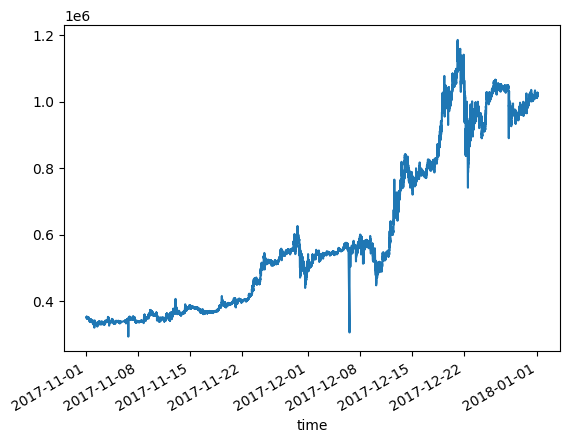

In [20]:
file_path = '/content/Cryptocurrency/sub_upbit_eth_min_tick.csv'
modify_data = pd.read_csv(file_path, index_col=0, parse_dates=True)
modify_data.loc['2017-11-01':'2017-12-31','close'].plot()

# Data Labeling

* Price Change Direction
*Using Moving Average
*Local Min-Max
*Trend Scanning
*Price Change Direc

## Price Change Direction


In [21]:
window = 10
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].shift(window)) + 1)
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index)

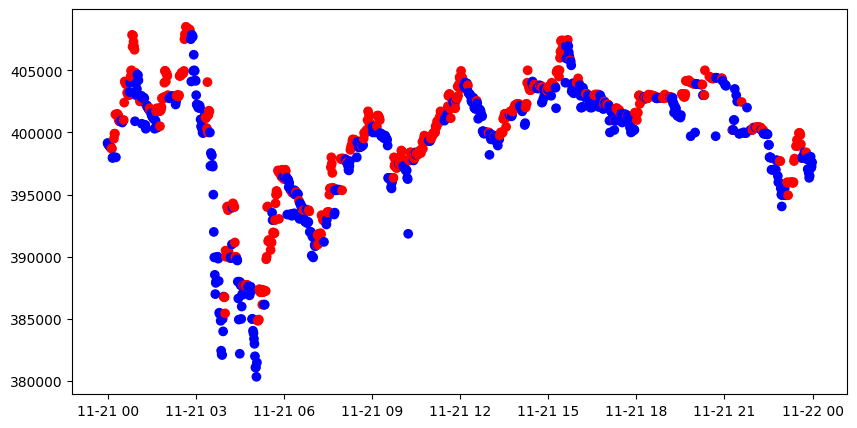

In [22]:
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = s_momentum_signal.loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

plt.figure(figsize=(10,5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

## Moving Average

In [23]:
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].rolling(window).mean()) + 1)
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index)

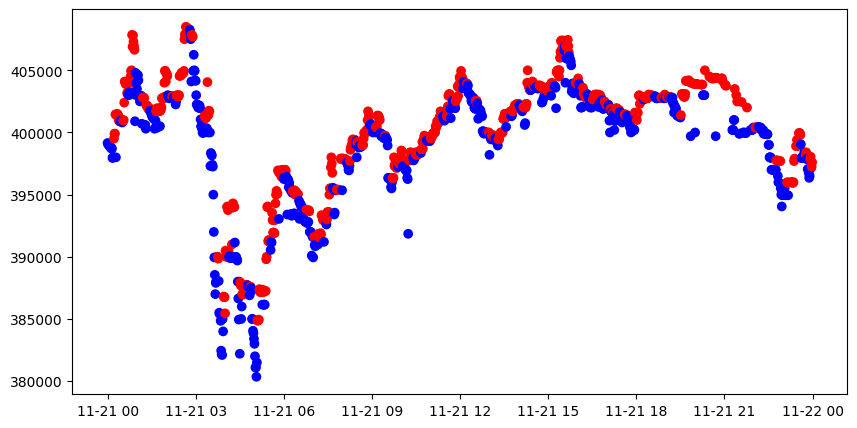

In [24]:
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = s_momentum_signal.loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

plt.figure(figsize=(10,5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

## Local Min-Max

In [25]:
# Local min / max 를 추출하기 위한 함수
def get_local_min_max(close, wait=3):
    min_value = close.iloc[0]
    max_value = close.iloc[0]
    n_cnt_min, n_cnt_max = 0, 0

    mins, maxes = [], []
    min_idxes, max_idxes = [], []
    b_min_update, b_max_update = False, False

    for idx, val in zip(close.index[1:], close.values[1:]):
        if val < min_value:
            min_value = val
            mins.append(min_value)
            min_idxes.append(idx)
            n_cnt_min = 0
            b_min_update = True
        if val > max_value:
            max_value = val
            maxes.append(max_value)
            max_idxes.append(idx)
            n_cnt_max = 0
            b_max_update = True

        if not b_max_update:
            b_min_update = False
            n_cnt_min += 1
            if n_cnt_min >= wait:
                max_value = min_value
                n_cnt_min = 0

        if not b_min_update:
            b_max_update = False
            n_cnt_max += 1
            if n_cnt_max >= wait:
                min_value = max_value
                n_cnt_max = 0

    return pd.DataFrame.from_dict({'min_time': min_idxes, 'local_min': mins}), pd.DataFrame.from_dict({'max_time': max_idxes, 'local_max': maxes})

In [26]:
mins, maxes = get_local_min_max(sub_data, wait=3)

(376546.5, 412585.0)

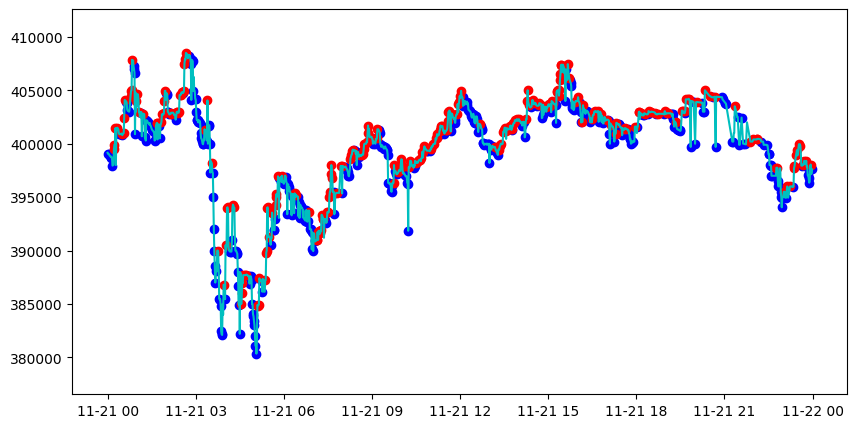

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(sub_data, 'c')
ax.scatter(mins.min_time, mins.local_min, c='blue')
ax.scatter(maxes.max_time, maxes.local_max, c='red')
ax.set_ylim([sub_data.min() * 0.99, sub_data.max()  * 1.01])

(376546.5, 412585.0)

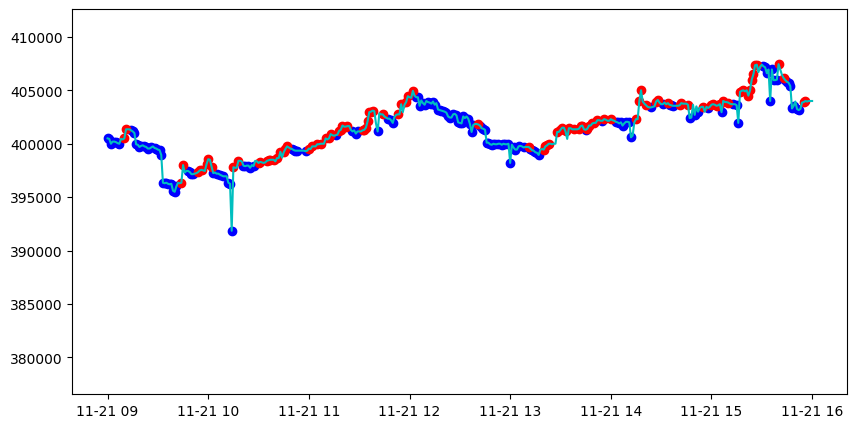

In [28]:
st_time, ed_time = '2017-11-21 09:00:00', '2017-11-21 16:00:00'

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(sub_data.loc[st_time:ed_time], 'c')
ax.scatter(mins.set_index('min_time', drop=False).min_time.loc[st_time:ed_time], mins.set_index('min_time').local_min.loc[st_time:ed_time], c='blue')
ax.scatter(maxes.set_index('max_time', drop=False).max_time.loc[st_time:ed_time], maxes.set_index('max_time').local_max.loc[st_time:ed_time], c='red')
ax.set_ylim([sub_data.min() * 0.99, sub_data.max()  * 1.01])

In [29]:
mins.shape[0], maxes.shape[0]

(477, 273)

## Trend Scanning

In [30]:
def t_val_lin_r(close):
    import statsmodels.api as sml

    # t-value from a linear trend
    x = np.ones((close.shape[0], 2))
    x[:, 1] = np.arange(close.shape[0])
    ols = sml.OLS(close, x).fit()
    return ols.tvalues[1]

In [31]:
look_forward_window = 60
min_sample_length = 5
step = 1
t1_array = []
t_values_array = []

In [32]:
# 이 코드 블럭은 실행에 20~30분정도 걸립니다.

molecule = modify_data['2017-11-01':'2017-11-30'].index
label = pd.DataFrame(index=molecule, columns=['t1', 't_val', 'bin'])
tmp_out = []

for ind in tqdm(molecule):
    subset = modify_data.loc[ind:, 'close'].iloc[:look_forward_window]  # 전방 탐색을 위한 샘플 추출
    if look_forward_window > subset.shape[0]:
        continue

    tmp_subset = pd.Series(index=subset.index[min_sample_length-1:subset.shape[0]-1])
    tval = []

    # 회귀분석을 통해 t 통계량값을 이용하여 추세 추정
    for forward_window in np.arange(min_sample_length, subset.shape[0]):
        df = subset.iloc[:forward_window]
        tval.append(t_val_lin_r(df.values))

    tmp_subset.loc[tmp_subset.index] = np.array(tval)
    idx_max = tmp_subset.replace([-np.inf, np.inf, np.nan], 0).abs().idxmax()
    tmp_t_val = tmp_subset[idx_max]
    tmp_out.append([tmp_subset.index[-1], tmp_t_val, np.sign(tmp_t_val)])

label.loc[molecule] = np.array(tmp_out)  # prevent leakage

label['t1'] = pd.to_datetime(label['t1'])
label['bin'] = pd.to_numeric(label['bin'], downcast='signed')

100%|██████████| 33384/33384 [15:11<00:00, 36.63it/s]


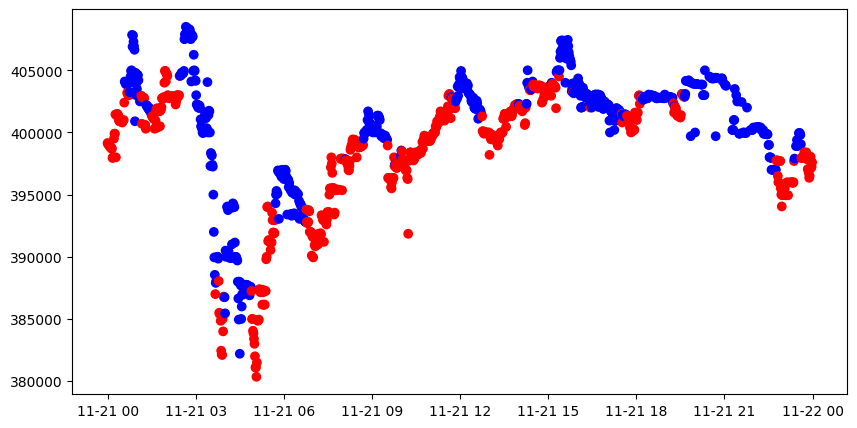

In [33]:
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = label['bin'].loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(sub_data.index, sub_data.values,
              c=c_sig['color'])

# Feature Engineering

① 환경구성 및 데이터 불러오기
- 필요 패키지 설치
- 데이터 불러오기

② Technical Index
- 기존 데이터셋(시가, 고가, 저가, 종가, 거래량)에서 기술적 지표(추세, 변동성, 거래량, 모멘텀)를 적용한 데이터셋 만들기
- 새로 만든 데이터셋에서 활용하고자 하는 시점에 대한 수익률, 변화율, 변동성을 적용

③ Feature Selection methods
- 특성추출(Feature Extraction)과 특성선택(Feature Selection) 중 특성선택을 하는 방법으로 접근하여 어떤 방법론이 있는지 확인해봅시다.
  * Feature Selection
  * Sequential Feature Selection
  * Shapley Additive explanations

## ① 환경구성 및 데이터 불러오기

In [34]:
!pip install ta==0.9.0
!pip install shap

In [35]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

# import sys
# sys.path.append('/aiffel/aiffel/fnguide/data/')
# from libs.feature_importance import importance as imp
from sklearn.feature_selection import SequentialFeatureSelector, RFECV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier

In [36]:
"""
mlfinlab
"""

"""
Module which implements feature importance algorithms as described in Chapter 8 of Advances in Financial Machine
Learning and Clustered Feature Importance algorithms as described in Chapter 6 Section 6.5.2 of Machine Learning for
Asset Managers.
"""

import pandas as pd
import numpy as np
from sklearn.metrics import log_loss


def mean_decrease_impurity(model, feature_names, clustered_subsets=None):
    """
    Advances in Financial Machine Learning, Snippet 8.2, page 115.
    MDI Feature importance
    Mean decrease impurity (MDI) is a fast, explanatory-importance (in-sample, IS) method specific to tree-based
    classifiers, like RF. At each node of each decision tree, the selected feature splits the subset it received in
    such a way that impurity is decreased. Therefore, we can derive for each decision tree how much of the overall
    impurity decrease can be assigned to each feature. And given that we have a forest of trees, we can average those
    values across all estimators and rank the features accordingly.
    Tip:
    Masking effects take place when some features are systematically ignored by tree-based classifiers in favor of
    others. In order to avoid them, set max_features=int(1) when using sklearn’s RF class. In this way, only one random
    feature is considered per level.
    Notes:
    * MDI cannot be generalized to other non-tree based classifiers
    * The procedure is obviously in-sample.
    * Every feature will have some importance, even if they have no predictive power whatsoever.
    * MDI has the nice property that feature importances add up to 1, and every feature importance is bounded between 0 and 1.
    * method does not address substitution effects in the presence of correlated features. MDI dilutes the importance of
      substitute features, because of their interchangeability: The importance of two identical features will be halved,
      as they are randomly chosen with equal probability.
    * Sklearn’s RandomForest class implements MDI as the default feature importance score. This choice is likely
      motivated by the ability to compute MDI on the fly, with minimum computational cost.
    Clustered Feature Importance( Machine Learning for Asset Manager snippet 6.4 page 86) :
    Clustered MDI  is the  modified version of MDI (Mean Decreased Impurity). It  is robust to substitution effect that
    takes place when two or more explanatory variables share a substantial amount of information (predictive power).CFI
    algorithm described by Dr Marcos Lopez de Prado  in Clustered Feature  Importance section of book Machine Learning
    for Asset Manager. Here  instead of  taking the importance  of  every feature, we consider the importance of every
    feature subsets, thus every feature receive the importance of subset it belongs to.
    :param model: (model object): Trained tree based classifier.
    :param feature_names: (list): Array of feature names.
    :param clustered_subsets: (list) Feature clusters for Clustered Feature Importance (CFI). Default None will not apply CFI.
                              Structure of the input must be a list of list/s i.e. a list containing the clusters/subsets of feature
                              name/s inside a list. E.g- [['I_0','I_1','R_0','R_1'],['N_1','N_2'],['R_3']]
    :return: (pd.DataFrame): Mean and standard deviation feature importance.
    """
    # Feature importance based on in-sample (IS) mean impurity reduction
    feature_imp_df = {i: tree.feature_importances_ for i, tree in enumerate(model.estimators_)}
    feature_imp_df = pd.DataFrame.from_dict(feature_imp_df, orient='index')
    feature_imp_df.columns = feature_names

    # Make sure that features with zero importance are not averaged, since the only reason for a 0 is that the feature
    # was not randomly chosen. Replace those values with np.nan
    feature_imp_df = feature_imp_df.replace(0, np.nan)  # Because max_features = 1

    if clustered_subsets is not None:
        # Getting subset wise importance
        importance = pd.DataFrame(index=feature_names, columns=['mean', 'std'])
        for subset in clustered_subsets: # Iterating over each cluster
            subset_feat_imp = feature_imp_df[subset].sum(axis=1)
            # Importance of each feature within a subsets is equal to the importance of that subset
            importance.loc[subset, 'mean'] = subset_feat_imp.mean()
            importance.loc[subset, 'std'] = subset_feat_imp.std()*subset_feat_imp.shape[0]**-.5
    else:
        importance = pd.concat({'mean': feature_imp_df.mean(),
                                'std': feature_imp_df.std() * feature_imp_df.shape[0] ** -0.5},
                               axis=1)

    importance /= importance['mean'].sum()
    return importance


def mean_decrease_accuracy(model, X, y, cv_gen, clustered_subsets=None, sample_weight_train=None,
                           sample_weight_score=None, scoring=log_loss, random_state=42):
    """
    Advances in Financial Machine Learning, Snippet 8.3, page 116-117.
    MDA Feature Importance
    Mean decrease accuracy (MDA) is a slow, predictive-importance (out-of-sample, OOS) method. First, it fits a
    classifier; second, it derives its performance OOS according to some performance score (accuracy, negative log-loss,
    etc.); third, it permutates each column of the features matrix (X), one column at a time, deriving the performance
    OOS after each column’s permutation. The importance of a feature is a function of the loss in performance caused by
    its column’s permutation. Some relevant considerations include:
    * This method can be applied to any classifier, not only tree-based classifiers.
    * MDA is not limited to accuracy as the sole performance score. For example, in the context of meta-labeling
      applications, we may prefer to score a classifier with F1 rather than accuracy. That is one reason a better
      descriptive name would have been “permutation importance.” When the scoring function does not correspond to a
      metric space, MDA results should be used as a ranking.
    * Like MDI, the procedure is also susceptible to substitution effects in the presence of correlated features.
      Given two identical features, MDA always considers one to be redundant to the other. Unfortunately, MDA will make
      both features appear to be outright irrelevant, even if they are critical.
    * Unlike MDI, it is possible that MDA concludes that all features are unimportant. That is because MDA is based on
      OOS performance.
    * The CV must be purged and embargoed.
    Clustered Feature Importance( Machine Learning for Asset Manager snippet 6.5 page 87) :
    Clustered MDA is the modified version of MDA (Mean Decreased Accuracy). It is robust to substitution effect that takes
    place when two or more explanatory variables share a substantial amount of information (predictive power).CFI algorithm
    described by Dr Marcos Lopez de Prado  in Clustered Feature  Importance (Presentation Slides)
    https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3517595. Instead of shuffling (permutating) all variables
    individually (like in MDA), we shuffle all variables in cluster together. Next, we follow all the  rest of the
    steps as in MDA. It can used by simply specifying the clustered_subsets argument.
    :param model: (sklearn.Classifier): Any sklearn classifier.
    :param X: (pd.DataFrame): Train set features.
    :param y: (pd.DataFrame, np.array): Train set labels.
    :param cv_gen: (cross_validation.PurgedKFold): Cross-validation object.
    :param clustered_subsets: (list) Feature clusters for Clustered Feature Importance (CFI). Default None will not apply CFI.
                              Structure of the input must be a list of list/s i.e. a list containing the clusters/subsets of feature
                              name/s inside a list. E.g- [['I_0','I_1','R_0','R_1'],['N_1','N_2'],['R_3']]
    :param sample_weight_train: (np.array) Sample weights used to train the model for each record in the dataset.
    :param sample_weight_score: (np.array) Sample weights used to evaluate the model quality.
    :param scoring: (function): Scoring function used to determine importance.
    :param random_state: (int) Random seed for shuffling the features.
    :return: (pd.DataFrame): Mean and standard deviation of feature importance.
    """

    if sample_weight_train is None:
        sample_weight_train = np.ones((X.shape[0],))

    if sample_weight_score is None:
        sample_weight_score = np.ones((X.shape[0],))

    fold_metrics_values, features_metrics_values = pd.Series(dtype='float64'), pd.DataFrame(columns=X.columns)
    # Generating a numpy random state object for the given random_state
    rs_obj = np.random.RandomState(seed=random_state)
    # Clustered feature subsets will be used for CFI if clustered_subsets exists else will operate on the single column as MDA
    feature_sets = clustered_subsets if clustered_subsets else [[x] for x in X.columns]
    for i, (train, test) in enumerate(cv_gen.split(X=X)):
        fit = model.fit(X=X.iloc[train, :], y=y.iloc[train], sample_weight=sample_weight_train[train])
        pred = fit.predict(X.iloc[test, :])

        # Get overall metrics value on out-of-sample fold
        if scoring == log_loss:
            prob = fit.predict_proba(X.iloc[test, :])
            fold_metrics_values.loc[i] = -scoring(y.iloc[test], prob, sample_weight=sample_weight_score[test],
                                                  labels=model.classes_)
        else:
            fold_metrics_values.loc[i] = scoring(y.iloc[test], pred, sample_weight=sample_weight_score[test])

        # Get feature specific metric on out-of-sample fold
        for j in feature_sets:
            X1_ = X.iloc[test, :].copy(deep=True)
            for j_i in j:
                rs_obj.shuffle(X1_[j_i].values)  # Permutation of a single column for MDA or through the whole subset for CFI
            if scoring == log_loss:
                prob = fit.predict_proba(X1_)
                features_metrics_values.loc[i, j] = -scoring(y.iloc[test], prob,
                                                             sample_weight=sample_weight_score[test],
                                                             labels=model.classes_)
            else:
                pred = fit.predict(X1_)
                features_metrics_values.loc[i, j] = scoring(y.iloc[test], pred,
                                                            sample_weight=sample_weight_score[test])

    importance = (-features_metrics_values).add(fold_metrics_values, axis=0)
    if scoring == log_loss:
        importance = importance / -features_metrics_values
    else:
        importance = importance / (1.0 - features_metrics_values).replace(0, np.nan)
    importance = pd.concat({'mean': importance.mean(), 'std': importance.std() * importance.shape[0] ** -.5}, axis=1)
    importance.replace([-np.inf, np.nan], 0, inplace=True)  # Replace infinite values

    return importance

In [40]:
csv_file_path = '/content/Cryptocurrency/sub_upbit_eth_min_tick.csv'
anno_file_name = '/content/Cryptocurrency/sub_upbit_eth_min_tick_label.pkl'

df_modify_data = pd.read_csv(file_path, index_col=0, parse_dates=True)
df_label_data = pd.read_pickle(anno_file_name)
df_sub_modify_data = df_modify_data.loc[df_label_data.index]

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
df_sub_modify_data = df_sub_modify_data.iloc[:1000]

In [41]:
df_sub_modify_data.head()

,open,high,low,close,volume
time,,,,,
2018-01-01 00:00:00,1028000,1028000,1026500,1028000,41.835689
2018-01-01 00:01:00,1028000,1029000,1026000,1028500,22.307810
2018-01-01 00:02:00,1028000,1029000,1028000,1028000,59.276102
2018-01-01 00:03:00,1028000,1028000,1014000,1014000,114.203740
2018-01-01 00:04:00,1020000,1027000,1014500,1025000,62.695404


In [42]:
df_label_data.head(), df_label_data.tail()

(time
 2018-01-01 00:00:00   -0.0
 2018-01-01 00:01:00   -0.0
 2018-01-01 00:02:00   -0.0
 2018-01-01 00:03:00   -1.0
 2018-01-01 00:04:00   -1.0
 Name: t_value, dtype: float64,
 time
 2019-11-03 10:29:00   NaN
 2019-11-03 10:30:00   NaN
 2019-11-03 10:31:00   NaN
 2019-11-03 10:32:00   NaN
 2019-11-03 10:33:00   NaN
 Name: t_value, dtype: float64)

In [43]:
mt = 1
fillna = False
df_ = df_sub_modify_data.copy()
open, high, low, close, volume = 'open', 'high', 'low', 'close', 'volume'
cols = [open, high, low, close, volume]

## Volume Index
# Chaikin Money Flow
df_["volume_cmf"] = ta.volume.ChaikinMoneyFlowIndicator(
                        high=df_[high], low=df_[low], close=df_[close], volume=df_[volume], window=20*mt, fillna=fillna
                    ).chaikin_money_flow()
# Force Index
df_["volume_fi"] = ta.volume.ForceIndexIndicator(
                        close=df_[close], volume=df_[volume], window=15*mt, fillna=fillna
                    ).force_index()
# Money Flow Indicator
df_["volume_mfi"] = ta.volume.MFIIndicator(
                        high=df_[high],
                        low=df_[low],
                        close=df_[close],
                        volume=df_[volume],
                        window=15*mt,
                        fillna=fillna,
                    ).money_flow_index()
# Ease of Movement
df_["volume_sma_em"] = ta.volume.EaseOfMovementIndicator(
                            high=df_[high], low=df_[low], volume=df_[volume], window=15*mt, fillna=fillna
                        ).sma_ease_of_movement()

# Volume Price Trend
df_["volume_vpt"] = ta.volume.VolumePriceTrendIndicator(
                        close=df_[close], volume=df_[volume], fillna=fillna
                    ).volume_price_trend()

## volatility index
# Average True Range
df_["volatility_atr"] = ta.volatility.AverageTrueRange(
                            close=df_[close], high=df_[high], low=df_[low], window=10*mt, fillna=fillna
                        ).average_true_range()

# Ulcer Index
df_["volatility_ui"] = ta.volatility.UlcerIndex(
                            close=df_[close], window=15*mt, fillna=fillna
                        ).ulcer_index()

## trend index
# MACD
df_["trend_macd_diff"] = ta.trend.MACD(
                            close=df_[close], window_slow=25*mt, window_fast=10*mt, window_sign=9, fillna=fillna
                        ).macd_diff()

# Average Directional Movement Index (ADX)
df_["trend_adx"] = ta.trend.ADXIndicator(
                        high=df_[high], low=df_[low], close=df_[close], window=15*mt, fillna=fillna
                    ).adx()

# TRIX Indicator
df_["trend_trix"] = ta.trend.TRIXIndicator(
                        close=df_[close], window=15*mt, fillna=fillna
                    ).trix()

# Mass Index
df_["trend_mass_index"] = ta.trend.MassIndex(
                            high=df_[high], low=df_[low], window_fast=10*mt, window_slow=25*mt, fillna=fillna
                        ).mass_index()

# DPO Indicator
df_["trend_dpo"] = ta.trend.DPOIndicator(
                        close=df_[close], window=20*mt, fillna=fillna
                    ).dpo()

# Aroon Indicator
df_["trend_aroon_ind"] = ta.trend.AroonIndicator(close=df_[close], window=20, fillna=fillna).aroon_indicator()

## momentum index
# Relative Strength Index (RSI)
df_["momentum_rsi"] = ta.momentum.RSIIndicator(close=df_[close], window=15*mt, fillna=fillna).rsi()

# Williams R Indicator
df_["momentum_wr"] = ta.momentum.WilliamsRIndicator(
                        high=df_[high], low=df_[low], close=df_[close], lbp=15*mt, fillna=fillna
                    ).williams_r()

In [44]:
# 결과 확인
df_

,open,high,low,close,volume,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,volatility_atr,volatility_ui,trend_macd_diff,trend_adx,trend_trix,trend_mass_index,trend_dpo,trend_aroon_ind,momentum_rsi,momentum_wr
time,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,1028000,1028000,1026500,1028000,41.835689,NaN,NaN,NaN,NaN,-0.796083,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:01:00,1028000,1029000,1026000,1028500,22.307810,NaN,NaN,NaN,NaN,-0.788285,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:02:00,1028000,1029000,1028000,1028000,59.276102,NaN,NaN,NaN,NaN,-0.017967,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:03:00,1028000,1028000,1014000,1014000,114.203740,NaN,NaN,NaN,NaN,-1.584121,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:04:00,1020000,1027000,1014500,1025000,62.695404,NaN,NaN,NaN,NaN,-0.875176,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 16:35:00,1052500,1052500,1052500,1052500,6.084122,-0.232633,-2275.848327,71.279251,-3.186964e+12,0.007381,1416.425464,0.361107,652.357742,20.661135,-0.018034,23.066052,-225.0,-35.0,52.934202,-0.0
2018-01-01 16:36:00,1052500,1052500,1049500,1050000,9.205537,-0.165805,-4868.097577,67.762226,-3.097651e+12,-0.021866,1574.782918,0.349329,482.768654,21.007559,-0.016660,23.029259,-2100.0,-35.0,44.041843,-62.5
2018-01-01 16:37:00,1050000,1050000,1049000,1049000,3.472849,-0.161093,-4693.691500,74.267351,-5.977131e+12,-0.025173,1517.304626,0.342452,280.010175,21.537826,-0.015683,22.971985,-1925.0,-35.0,41.083991,-87.5


In [45]:
windows_mom = [5, 10, 20]
windows_std = [30]

for i in windows_mom:
    df_[f'vol_change_{i}'] = df_.volume.pct_change(i).round(6)
    df_[f'ret_{i}'] = df_.close.pct_change(i).round(6)

for i in windows_std:
    df_[f'std_{i}'] = df_.close.rolling(i).std()
    df_[f'vol_std_{i}'] = df_.volume.rolling(i).std()

In [46]:
# 결과 확인
df_

,open,high,low,close,volume,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,...,momentum_rsi,momentum_wr,vol_change_5,ret_5,vol_change_10,ret_10,vol_change_20,ret_20,std_30,vol_std_30
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,1028000,1028000,1026500,1028000,41.835689,NaN,NaN,NaN,NaN,-0.796083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:01:00,1028000,1029000,1026000,1028500,22.307810,NaN,NaN,NaN,NaN,-0.788285,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:02:00,1028000,1029000,1028000,1028000,59.276102,NaN,NaN,NaN,NaN,-0.017967,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:03:00,1028000,1028000,1014000,1014000,114.203740,NaN,NaN,NaN,NaN,-1.584121,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:04:00,1020000,1027000,1014500,1025000,62.695404,NaN,NaN,NaN,NaN,-0.875176,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 16:35:00,1052500,1052500,1052500,1052500,6.084122,-0.232633,-2275.848327,71.279251,-3.186964e+12,0.007381,...,52.934202,-0.0,-0.817192,0.002381,-0.265538,0.003815,0.703781,0.000000,1811.600550,15.025354
2018-01-01 16:36:00,1052500,1052500,1049500,1050000,9.205537,-0.165805,-4868.097577,67.762226,-3.097651e+12,-0.021866,...,44.041843,-62.5,0.394890,0.000000,0.274989,0.001431,-0.625893,-0.002375,1787.568824,9.944774
2018-01-01 16:37:00,1050000,1050000,1049000,1049000,3.472849,-0.161093,-4693.691500,74.267351,-5.977131e+12,-0.025173,...,41.083991,-87.5,-0.279019,-0.001903,-0.609186,0.000477,-0.849066,-0.003325,1763.291071,9.932495


In [47]:
df_tmp_data = df_.join(df_label_data).dropna()
X, y = df_tmp_data.iloc[:, 5:-1], df_tmp_data.iloc[:, -1]

sc = StandardScaler()
X_sc = sc.fit_transform(X)
X_sc = pd.DataFrame(X_sc, index=X.index, columns=X.columns)

In [48]:
X_sc.head()

,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,volatility_atr,volatility_ui,trend_macd_diff,trend_adx,trend_trix,...,momentum_rsi,momentum_wr,vol_change_5,ret_5,vol_change_10,ret_10,vol_change_20,ret_20,std_30,vol_std_30
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:43:00,1.035464,-0.186753,0.065427,0.391695,0.143181,1.474065,0.054076,0.103695,0.930692,-0.078062,...,-0.141586,0.073599,-0.268825,-0.053926,-0.273922,-0.077989,-0.359687,0.617241,-0.335632,0.273404
2018-01-01 00:44:00,1.054026,0.125880,-0.011156,0.814123,0.544363,1.478520,0.017250,0.639945,0.771813,-0.051294,...,0.344922,1.111779,-0.209690,2.237163,-0.263511,0.036043,-0.266915,0.940844,-0.262646,0.291664
2018-01-01 00:45:00,1.042978,-0.023653,0.063195,1.052689,0.218332,1.290057,-0.020738,0.714133,0.598850,-0.015958,...,0.067032,0.544625,-0.124252,0.554780,-0.278339,0.150308,-0.252720,0.942325,-0.237456,0.301886
2018-01-01 00:46:00,1.016133,0.880060,-0.281931,0.928143,1.068429,1.633699,-0.020738,1.434675,0.454452,0.071047,...,0.783648,1.457839,0.168697,2.536405,-0.228841,0.833801,-0.227291,1.672326,-0.022928,0.256716
2018-01-01 00:47:00,0.893440,0.486864,-0.562722,-0.026395,0.862103,1.942977,0.088583,0.921217,0.319680,0.131133,...,-0.191611,-0.257415,-0.080204,0.402681,-0.380178,0.036276,-0.340320,0.454122,-0.018291,0.317671


# Data Modeling

## Random Forest

In [49]:
rfc = RandomForestClassifier(class_weight='balanced')
rfc.fit(X_sc, y)

RandomForestClassifier(class_weight='balanced')

In [50]:
# LMS와 다르게 우리는 함수를 직접 호출해줘서 imp. 을 지웠습니다
# feat_imp = imp.mean_decrease_impurity(rfc, X.columns)
feat_imp = mean_decrease_impurity(rfc, X.columns)

In [51]:
feat_imp

,mean,std
volume_cmf,0.049377,0.002230
volume_fi,0.044968,0.002212
volume_mfi,0.049235,0.002465
volume_sma_em,0.035191,0.001727
volume_vpt,0.021203,0.001243
volatility_atr,0.079287,0.003332
volatility_ui,0.048612,0.002021
trend_macd_diff,0.077122,0.004172
trend_adx,0.059190,0.002765
trend_trix,0.067970,0.003058


In [52]:
svc_rbf = SVC(kernel='rbf', probability=True)
cv = KFold(n_splits=5)
feat_imp_mda = mean_decrease_accuracy(svc_rbf, X_sc, y, cv_gen=cv)

In [53]:
def plot_feature_importance(importance_df, save_fig=False, output_path=None):
    # Plot mean imp bars with std
    plt.figure(figsize=(10, importance_df.shape[0] / 5))
    importance_df.sort_values('mean', ascending=True, inplace=True)
    importance_df['mean'].plot(kind='barh', color='b', alpha=0.25, xerr=importance_df['std'], error_kw={'ecolor': 'r'})
    if save_fig:
        plt.savefig(output_path)
    else:
        plt.show()

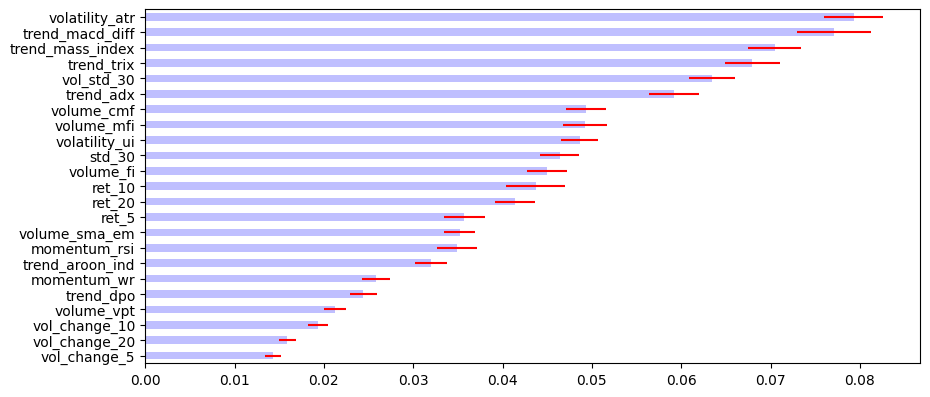

In [54]:
# volatility_atr : 시장의 변동성(진폭)을 측정하는 지표입니다
# Average True Range (ATR)
plot_feature_importance(feat_imp)

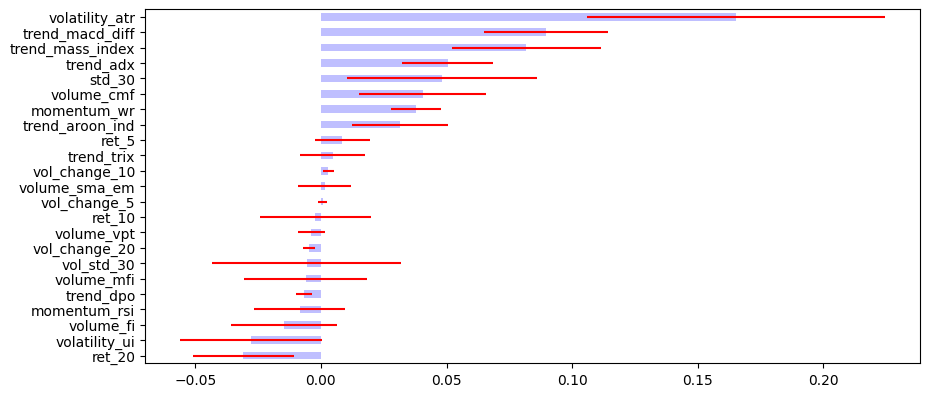

In [55]:
plot_feature_importance(feat_imp_mda)

In [56]:
svc_rbf = SVC(kernel='linear', probability=True)
rfe_cv = RFECV(svc_rbf, cv=cv)
rfe_fitted = rfe_cv.fit(X_sc, y)

In [57]:
rfe_df = pd.DataFrame([rfe_fitted.support_, rfe_fitted.ranking_], columns=X_sc.columns).T.rename(columns={0:"Optimal_Features", 1:"Ranking"})
rfe_df

,Optimal_Features,Ranking
volume_cmf,False,12
volume_fi,False,4
volume_mfi,False,14
volume_sma_em,False,7
volume_vpt,False,8
volatility_atr,True,1
volatility_ui,False,11
trend_macd_diff,True,1
trend_adx,False,19
trend_trix,False,10


In [58]:
rfe_df[rfe_df["Optimal_Features"]==True]

,Optimal_Features,Ranking
volatility_atr,True,1
trend_macd_diff,True,1
std_30,True,1


In [59]:
n = 2

sfs_forward = SequentialFeatureSelector(svc_rbf, n_features_to_select=n, direction='forward')
sfs_fitted = sfs_forward.fit(X_sc, y)

In [ ]:
sfs_rank = sfs_fitted.get_support()

# 최신 버전은 {} 대신 []를 사용해야함
#sfs_df = pd.DataFrame(sfs_rank, index=X_sc.columns, columns={"Optimal_Features"})
sfs_df = pd.DataFrame(sfs_rank, index=X_sc.columns, columns=["Optimal_Features"])

sfs_df [sfs_df ["Optimal_Features"]==True].index

In [ ]:
# !pip install --upgrade typing_extensions
# -> LMS에서 오류가남 버전 재설치를 해야한다
import shap
# 모델 output을 raw로 바꿔주기
explainer = shap.TreeExplainer(rfc, model_output="raw")
shap_value = explainer.shap_values(X_sc)

In [ ]:
shap_value.shape

In [ ]:
# 각 클래스에 대한 각각의 plot을 그려줘야함

# 클래스 0에 대한 SHAP summary plot
shap.summary_plot(shap_value[:, :, 0], X_sc, class_names='class 0')

# 클래스 1
shap.summary_plot(shap_value[:, :, 1], X_sc, class_names='class 1')

# 클래스 2
shap.summary_plot(shap_value[:, :, 2], X_sc, class_names='class 2')

In [ ]:
# 절댓값 평균으로 전체 feature 중요도 요약
mean_shap = np.mean(np.abs(shap_value), axis=(0, 2))  # over samples and classes
shap_df = pd.Series(mean_shap, index=X_sc.columns).sort_values(ascending=False)
print(shap_df)

In [60]:
output_file_path = '/content/Cryptocurrency/sub_upbit_eth_min_tick_label.pkl'
df_tmp_data.to_pickle(output_file_path)

In [61]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, roc_curve

# sys.path.append('/aiffel/aiffel/fnguide/data/')
# from libs.mlutil.pkfold import PKFold

In [62]:
"""
Created on Fri Dec  6 19:41:30 2019

@author: sukji
"""
from typing import Callable
import pandas as pd
import numpy as np

from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
from sklearn.base import ClassifierMixin
from sklearn.model_selection import BaseCrossValidator

def ml_get_train_times1(samples_info_sets: pd.Series, test_times: pd.Series) -> pd.Series:
    # pylint: disable=invalid-name
    """
    Advances in Financial Machine Learning, Snippet 7.1, page 106.

    Purging observations in the training set

    This function find the training set indexes given the information on which each record is based
    and the range for the test set.
    Given test_times, find the times of the training observations.

    :param samples_info_sets: (pd.Series) The information range on which each record is constructed from
        *samples_info_sets.index*: Time when the information extraction started.
        *samples_info_sets.value*: Time when the information extraction ended.
    :param test_times: (pd.Series) Times for the test dataset.
    :return: (pd.Series) Training set
    """
    train = samples_info_sets.copy(deep=True)

    start = test_times.min()
    end = test_times.max()

    first = test_times.index[0]
    last = test_times.index[-1]

    df0 = train[(train < first) | (train.index > end)].index  # Train starts within test
    return df0

class PKFold(KFold):
    """
    Extend KFold class to work with labels that span intervals

    The train is purged of observations overlapping test-label intervals
    Test set is assumed contiguous (shuffle=False), w/o training samples in between

    :param n_splits: (int) The number of splits. Default to 3
    :param samples_info_sets: (pd.Series) The information range on which each record is constructed from
        *samples_info_sets.index*: Time when the information extraction started.
        *samples_info_sets.value*: Time when the information extraction ended.
    :param pct_embargo: (float) Percent that determines the embargo size.
    """

    def __init__(self,
                 n_splits: int = 3,
                 samples_info_sets: pd.Series = None,
                 pct_embargo: float = 0.):

        if not isinstance(samples_info_sets, pd.Series):
            raise ValueError('The samples_info_sets param must be a pd.Series')
        super(PKFold, self).__init__(n_splits, shuffle=False, random_state=None)

        self.samples_info_sets = samples_info_sets
        self.pct_embargo = pct_embargo

    # noinspection PyPep8Naming
    def split(self,
              X: pd.DataFrame,
              y: pd.Series = None,
              groups=None):
        """
        The main method to call for the PurgedKFold class

        :param X: (pd.DataFrame) Samples dataset that is to be split
        :param y: (pd.Series) Sample labels series
        :param groups: (array-like), with shape (n_samples,), optional
            Group labels for the samples used while splitting the dataset into
            train/test set.
        :return: (tuple) [train list of sample indices, and test list of sample indices]
        """
        if X.shape[0] != self.samples_info_sets.shape[0]:
            raise ValueError("X and the 'samples_info_sets' series param must be the same length")

        indices: np.ndarray = np.arange(X.shape[0])
        embargo: int = int(X.shape[0] * self.pct_embargo)

        test_ranges: [(int, int)] = [(ix[0], ix[-1] + 1) for ix in np.array_split(np.arange(X.shape[0]), self.n_splits)]
        for start_ix, end_ix in test_ranges:
            test_indices = indices[start_ix:end_ix]

            if end_ix < X.shape[0]:
                end_ix += embargo

            test_times = pd.Series(index=[self.samples_info_sets.index[start_ix]], data=[self.samples_info_sets[end_ix-1]])
            #train_times = ml_get_train_times(self.samples_info_sets, test_times)
            train_times = ml_get_train_times1(self.samples_info_sets, test_times)

            train_indices = []
            for train_ix in train_times:
                train_indices.append(self.samples_info_sets.index.get_loc(train_ix))
            yield np.array(train_indices), test_indices

In [63]:
data_file_path = '/content/Cryptocurrency/sub_upbit_eth_min_feature_labels.pkl'
df_data = pd.read_pickle(data_file_path)
df_data['t_value'] = df_data['t_value'].apply(lambda x: x if x == 1 else 0)

In [64]:
df_data['t_value'].value_counts()

,count
t_value,
0.0,609576
1.0,299269


In [65]:
train_ratio, test_ratio = 0.7, 0.2
n_train = int(np.round(len(df_data) * train_ratio))
n_test = int(np.round(len(df_data) * test_ratio))

In [66]:
X, y = df_data.iloc[:, 5:-1], df_data.iloc[:, -1]

sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [67]:
train_x, test_x, train_y, test_y = X_sc[:n_train, :], X_sc[-n_test:, :], y.iloc[:n_train], y.iloc[-n_test:]

train_x = pd.DataFrame(train_x, index=train_y.index, columns=X.columns)
train_y = pd.Series(train_y, index=train_y.index)
test_x = pd.DataFrame(test_x, index=test_y.index, columns=X.columns)
test_y = pd.Series(test_y, index=test_y.index)

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
train_x = train_x[:1000]
train_y = train_y[:1000]

In [68]:
n_cv = 4
t1 = pd.Series(train_y.index.values, index=train_y.index)
# purged K-Fold
cv = PKFold(n_cv, t1, 0)

In [69]:
# 최대 20분정도가 소요됩니다. 시간이 부족하다면 파라미터를 조절하여 진행하세요.
# 파라미터 명을 변경해야합니다
# 'base_estimator__max_depth': [3,5,10,20],
# base 모조리 빼버리기

bc_params = {'n_estimators': [5, 10, 20],
             'max_features': [0.5, 0.7],
             'estimator__max_depth': [3,5,10,20],
             'estimator__max_features': [None, 'auto'],
             'estimator__min_samples_leaf': [3, 5, 10],
             'bootstrap_features': [False, True]
            }

rfc = RandomForestClassifier(class_weight='balanced')
bag_rfc = BaggingClassifier(rfc)
gs_rfc = GridSearchCV(bag_rfc, bc_params, cv=cv, n_jobs=-1, verbose=1)
gs_rfc.fit(train_x, train_y)
gs_rfc_best = gs_rfc.best_estimator_

Fitting 4 folds for each of 288 candidates, totalling 1152 fits


In [70]:
gs_rfc_best.fit(train_x, train_y)

BaggingClassifier(bootstrap_features=True,
                  estimator=RandomForestClassifier(class_weight='balanced',
                                                   max_depth=10,
                                                   max_features=None,
                                                   min_samples_leaf=3),
                  max_features=0.7)

In [71]:
pred_y = gs_rfc_best.predict(test_x)
prob_y = gs_rfc_best.predict_proba(test_x)

In [72]:
confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)

print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

================= confusion matrix ====================
[[97868 23444]
 [42771 17686]]
정확도:0.6357189619792154, 정밀도:0.4300024313153416, 재현율:0.29253849843690555


auc:0.5496423697671208


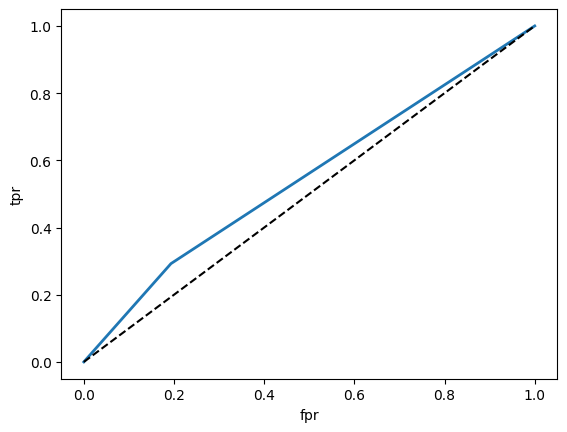

In [73]:
fpr, tpr, thresholds = roc_curve(test_y, pred_y)
auc = roc_auc_score(test_y, pred_y)
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')